# VAERepresentation - Training

In [1]:
import os, datetime
import numpy as np
import joblib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer,text_to_word_sequence

## Collect HTML files

Load the HTML files

In [2]:
files = []

for f in os.listdir(os.path.join(os.getcwd(),'html')):
    fd = open(os.path.join(os.getcwd(),'html',f),'r')
    content = fd.read()
    files.append(content)
    fd.close()

Add a mock file as a concatentation of a previous one

In [3]:
files.append(files[0]*10)

## Preprocess the files

Define the padding and trimming parameters

In [4]:
padding='post'

maxlen=200
truncating='post'

Load the tokenizer

In [6]:
SQLi_tokenizer = joblib.load('ignore_tokenizer_20210318153153509112')

Convert the pages into token sequences:

In [7]:
tokens_list = SQLi_tokenizer.texts_to_sequences(files)

Pad and trim the sequences to fit them into an array:

In [8]:
tokens_array = keras.preprocessing.sequence.pad_sequences(tokens_list, padding=padding, maxlen=maxlen, truncating=truncating)

## Defining VAE

Instantiating a VAE module built following [https://keras.io/examples/generative/vae/](https://keras.io/examples/generative/vae/).

*Sampling layer with reparametrization trick* $z_i\sim\mathcal{N}(\mu_\phi, \sigma_\phi)$

In [9]:
class Sampling(layers.Layer):
    
    def call(self,inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(.5 * z_log_var) * epsilon

*Encoder* $Q_\phi(z \vert x)$

In [10]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(200,))

x = layers.Dense(100,activation='relu')(encoder_inputs)
x = layers.Dense(25,activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean,z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean,z_log_var,z], name='encoder')
encoder.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
______________________________________________________________________________________

*Decoder* $P_\theta(x\vert z)$

In [11]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(25,activation='relu')(latent_inputs)
x = layers.Dense(100,activation='relu')(x)
decoder_outputs = layers.Dense(200,activation='relu')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                75        
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2600      
_________________________________________________________________
dense_4 (Dense)              (None, 200)               20200     
Total params: 22,875
Trainable params: 22,875
Non-trainable params: 0
_________________________________________________________________


*VAE with KL+reconstruction loss*

In [12]:
class VAE(keras.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super(VAE,self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self,data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)           
            reconstruction = self.decoder(z)
            print(reconstruction)
            reconstruction_loss = keras.losses.mean_squared_error(data,reconstruction)
            #reconstruction_loss = tf.reduce_sum(keras.losses.mean_squared_error(data,reconstruction), axis=1)
            kl_loss = -.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = (tf.reduce_sum(kl_loss,axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss,self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads,self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            'loss': self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result(),
        }

## Training the VAE

Instantiating and training the model

In [13]:
vae = VAE(encoder,decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(tokens_array, epochs=2000, batch_size=3)

Epoch 1/2000
Tensor("decoder/dense_4/Relu:0", shape=(None, 200), dtype=float32)
Tensor("decoder/dense_4/Relu:0", shape=(None, 200), dtype=float32)
2/2 [==============================] - 0s 2ms/step - loss: 1116.6647 - reconstruction_loss: 267.1849 - kl_loss: 820.5369
Epoch 2/2000
2/2 [==============================] - 0s 501us/step - loss: 721.7018 - reconstruction_loss: 267.6423 - kl_loss: 463.8687
Epoch 3/2000
2/2 [==============================] - 0s 500us/step - loss: 497.1390 - reconstruction_loss: 272.8032 - kl_loss: 201.9297
Epoch 4/2000
2/2 [==============================] - 0s 501us/step - loss: 400.6568 - reconstruction_loss: 279.3001 - kl_loss: 108.4395
Epoch 5/2000
2/2 [==============================] - 0s 500us/step - loss: 411.7308 - reconstruction_loss: 279.2017 - kl_loss: 103.3879
Epoch 6/2000
2/2 [==============================] - 0s 1ms/step - loss: 331.7425 - reconstruction_loss: 279.8861 - kl_loss: 81.0153
Epoch 7/2000
2/2 [==============================] - 0s 500us

2/2 [==============================] - 0s 501us/step - loss: 170.1791 - reconstruction_loss: 126.8729 - kl_loss: 36.9884
Epoch 62/2000
2/2 [==============================] - 0s 1ms/step - loss: 153.1177 - reconstruction_loss: 131.3920 - kl_loss: 32.3962
Epoch 63/2000
2/2 [==============================] - 0s 500us/step - loss: 168.0205 - reconstruction_loss: 129.9166 - kl_loss: 28.7987
Epoch 64/2000
2/2 [==============================] - 0s 501us/step - loss: 172.8649 - reconstruction_loss: 131.0185 - kl_loss: 31.3364
Epoch 65/2000
2/2 [==============================] - 0s 500us/step - loss: 146.3141 - reconstruction_loss: 128.0307 - kl_loss: 31.4439
Epoch 66/2000
2/2 [==============================] - 0s 501us/step - loss: 144.8414 - reconstruction_loss: 126.4352 - kl_loss: 28.0926
Epoch 67/2000
2/2 [==============================] - 0s 1ms/step - loss: 144.8583 - reconstruction_loss: 131.9165 - kl_loss: 26.3041
Epoch 68/2000
2/2 [==============================] - 0s 501us/step - loss

2/2 [==============================] - 0s 501us/step - loss: 110.1547 - reconstruction_loss: 81.0955 - kl_loss: 20.7631
Epoch 122/2000
2/2 [==============================] - 0s 501us/step - loss: 110.5705 - reconstruction_loss: 86.9140 - kl_loss: 21.2043
Epoch 123/2000
2/2 [==============================] - 0s 1ms/step - loss: 92.3083 - reconstruction_loss: 79.1407 - kl_loss: 22.0367
Epoch 124/2000
2/2 [==============================] - 0s 1ms/step - loss: 98.7675 - reconstruction_loss: 81.4625 - kl_loss: 22.8979
Epoch 125/2000
2/2 [==============================] - 0s 500us/step - loss: 109.8349 - reconstruction_loss: 83.7689 - kl_loss: 21.3087
Epoch 126/2000
2/2 [==============================] - 0s 500us/step - loss: 98.1905 - reconstruction_loss: 83.3272 - kl_loss: 19.6183
Epoch 127/2000
2/2 [==============================] - 0s 500us/step - loss: 94.8348 - reconstruction_loss: 78.2255 - kl_loss: 21.7767
Epoch 128/2000
2/2 [==============================] - 0s 501us/step - loss: 11

2/2 [==============================] - 0s 501us/step - loss: 84.9950 - reconstruction_loss: 66.1627 - kl_loss: 16.9222
Epoch 183/2000
2/2 [==============================] - 0s 501us/step - loss: 84.3033 - reconstruction_loss: 74.3858 - kl_loss: 14.7019
Epoch 184/2000
2/2 [==============================] - 0s 500us/step - loss: 89.3607 - reconstruction_loss: 69.0237 - kl_loss: 15.7279
Epoch 185/2000
2/2 [==============================] - 0s 501us/step - loss: 78.7465 - reconstruction_loss: 65.9490 - kl_loss: 18.9848
Epoch 186/2000
2/2 [==============================] - 0s 501us/step - loss: 84.5464 - reconstruction_loss: 70.5307 - kl_loss: 18.8037
Epoch 187/2000
2/2 [==============================] - 0s 501us/step - loss: 89.1480 - reconstruction_loss: 72.9591 - kl_loss: 17.4831
Epoch 188/2000
2/2 [==============================] - 0s 501us/step - loss: 79.3197 - reconstruction_loss: 67.0991 - kl_loss: 18.1637
Epoch 189/2000
2/2 [==============================] - 0s 501us/step - loss: 8

2/2 [==============================] - 0s 500us/step - loss: 66.9234 - reconstruction_loss: 55.5436 - kl_loss: 14.2086
Epoch 244/2000
2/2 [==============================] - 0s 500us/step - loss: 63.8520 - reconstruction_loss: 54.4166 - kl_loss: 14.8972
Epoch 245/2000
2/2 [==============================] - 0s 1ms/step - loss: 67.2961 - reconstruction_loss: 54.8597 - kl_loss: 14.8445
Epoch 246/2000
2/2 [==============================] - 0s 501us/step - loss: 72.0028 - reconstruction_loss: 54.7129 - kl_loss: 14.0928
Epoch 247/2000
2/2 [==============================] - 0s 500us/step - loss: 73.7081 - reconstruction_loss: 55.5694 - kl_loss: 12.9946
Epoch 248/2000
2/2 [==============================] - 0s 500us/step - loss: 64.7519 - reconstruction_loss: 55.1475 - kl_loss: 12.5386
Epoch 249/2000
2/2 [==============================] - 0s 501us/step - loss: 74.6983 - reconstruction_loss: 58.4783 - kl_loss: 12.4576
Epoch 250/2000
2/2 [==============================] - 0s 500us/step - loss: 71.

2/2 [==============================] - 0s 501us/step - loss: 67.4040 - reconstruction_loss: 53.6711 - kl_loss: 12.2663
Epoch 305/2000
2/2 [==============================] - 0s 501us/step - loss: 64.4624 - reconstruction_loss: 51.8870 - kl_loss: 11.1400
Epoch 306/2000
2/2 [==============================] - 0s 501us/step - loss: 67.8722 - reconstruction_loss: 56.2309 - kl_loss: 11.0388
Epoch 307/2000
2/2 [==============================] - 0s 500us/step - loss: 60.0566 - reconstruction_loss: 52.3083 - kl_loss: 12.0032
Epoch 308/2000
2/2 [==============================] - 0s 1ms/step - loss: 70.2276 - reconstruction_loss: 55.0396 - kl_loss: 12.6344
Epoch 309/2000
2/2 [==============================] - 0s 501us/step - loss: 59.0860 - reconstruction_loss: 51.6593 - kl_loss: 11.7873
Epoch 310/2000
2/2 [==============================] - 0s 501us/step - loss: 71.7099 - reconstruction_loss: 59.4917 - kl_loss: 10.5622
Epoch 311/2000
2/2 [==============================] - 0s 1ms/step - loss: 61.67

2/2 [==============================] - 0s 501us/step - loss: 61.4126 - reconstruction_loss: 52.1510 - kl_loss: 9.7017
Epoch 366/2000
2/2 [==============================] - 0s 501us/step - loss: 70.6559 - reconstruction_loss: 57.6292 - kl_loss: 9.8671
Epoch 367/2000
2/2 [==============================] - 0s 501us/step - loss: 64.7314 - reconstruction_loss: 52.1634 - kl_loss: 9.8571
Epoch 368/2000
2/2 [==============================] - 0s 501us/step - loss: 67.5465 - reconstruction_loss: 56.6080 - kl_loss: 10.5421
Epoch 369/2000
2/2 [==============================] - 0s 501us/step - loss: 59.0605 - reconstruction_loss: 51.0681 - kl_loss: 10.8159
Epoch 370/2000
2/2 [==============================] - 0s 1ms/step - loss: 60.6973 - reconstruction_loss: 50.2653 - kl_loss: 11.5150
Epoch 371/2000
2/2 [==============================] - 0s 1ms/step - loss: 65.2437 - reconstruction_loss: 51.2095 - kl_loss: 11.1227
Epoch 372/2000
2/2 [==============================] - 0s 1ms/step - loss: 60.2322 - 

2/2 [==============================] - 0s 493us/step - loss: 67.0720 - reconstruction_loss: 56.0663 - kl_loss: 10.3124
Epoch 427/2000
2/2 [==============================] - 0s 501us/step - loss: 55.1836 - reconstruction_loss: 48.2242 - kl_loss: 11.0894
Epoch 428/2000
2/2 [==============================] - 0s 500us/step - loss: 59.8372 - reconstruction_loss: 47.7739 - kl_loss: 11.5873
Epoch 429/2000
2/2 [==============================] - 0s 489us/step - loss: 56.6367 - reconstruction_loss: 48.9353 - kl_loss: 11.6161
Epoch 430/2000
2/2 [==============================] - 0s 501us/step - loss: 56.0146 - reconstruction_loss: 49.0461 - kl_loss: 10.9870
Epoch 431/2000
2/2 [==============================] - 0s 500us/step - loss: 62.7760 - reconstruction_loss: 48.0416 - kl_loss: 11.4005
Epoch 432/2000
2/2 [==============================] - 0s 500us/step - loss: 63.3618 - reconstruction_loss: 49.3458 - kl_loss: 10.2040
Epoch 433/2000
2/2 [==============================] - 0s 501us/step - loss: 6

2/2 [==============================] - 0s 501us/step - loss: 59.9398 - reconstruction_loss: 47.4501 - kl_loss: 8.6069
Epoch 488/2000
2/2 [==============================] - 0s 500us/step - loss: 56.7301 - reconstruction_loss: 50.0843 - kl_loss: 9.7802
Epoch 489/2000
2/2 [==============================] - 0s 500us/step - loss: 55.9411 - reconstruction_loss: 46.5710 - kl_loss: 9.0435
Epoch 490/2000
2/2 [==============================] - 0s 500us/step - loss: 55.9372 - reconstruction_loss: 49.2445 - kl_loss: 7.6476
Epoch 491/2000
2/2 [==============================] - 0s 501us/step - loss: 59.4230 - reconstruction_loss: 51.9371 - kl_loss: 7.4232
Epoch 492/2000
2/2 [==============================] - 0s 501us/step - loss: 58.0419 - reconstruction_loss: 45.6171 - kl_loss: 7.7482
Epoch 493/2000
2/2 [==============================] - 0s 500us/step - loss: 52.3891 - reconstruction_loss: 47.5356 - kl_loss: 9.1413
Epoch 494/2000
2/2 [==============================] - 0s 501us/step - loss: 61.2553 

2/2 [==============================] - 0s 500us/step - loss: 55.4503 - reconstruction_loss: 49.5994 - kl_loss: 9.9709
Epoch 549/2000
2/2 [==============================] - 0s 501us/step - loss: 55.9908 - reconstruction_loss: 43.9004 - kl_loss: 9.9000
Epoch 550/2000
2/2 [==============================] - 0s 500us/step - loss: 72.9004 - reconstruction_loss: 81.5370 - kl_loss: 8.2410
Epoch 551/2000
2/2 [==============================] - 0s 1ms/step - loss: 53.2014 - reconstruction_loss: 46.5145 - kl_loss: 9.3726
Epoch 552/2000
2/2 [==============================] - 0s 500us/step - loss: 56.3632 - reconstruction_loss: 51.4922 - kl_loss: 10.4155
Epoch 553/2000
2/2 [==============================] - 0s 1ms/step - loss: 54.0082 - reconstruction_loss: 46.5248 - kl_loss: 11.9607
Epoch 554/2000
2/2 [==============================] - 0s 500us/step - loss: 57.7154 - reconstruction_loss: 49.7294 - kl_loss: 11.8863
Epoch 555/2000
2/2 [==============================] - 0s 500us/step - loss: 58.0654 -

2/2 [==============================] - 0s 501us/step - loss: 51.3225 - reconstruction_loss: 38.3971 - kl_loss: 8.9743
Epoch 610/2000
2/2 [==============================] - 0s 1ms/step - loss: 49.7166 - reconstruction_loss: 41.2974 - kl_loss: 8.2037
Epoch 611/2000
2/2 [==============================] - 0s 500us/step - loss: 46.6095 - reconstruction_loss: 43.4721 - kl_loss: 6.6917
Epoch 612/2000
2/2 [==============================] - 0s 501us/step - loss: 53.3770 - reconstruction_loss: 46.2211 - kl_loss: 6.7000
Epoch 613/2000
2/2 [==============================] - 0s 500us/step - loss: 50.6394 - reconstruction_loss: 40.5224 - kl_loss: 7.2146
Epoch 614/2000
2/2 [==============================] - 0s 1ms/step - loss: 48.6899 - reconstruction_loss: 39.8769 - kl_loss: 9.1031
Epoch 615/2000
2/2 [==============================] - 0s 500us/step - loss: 51.6032 - reconstruction_loss: 40.6211 - kl_loss: 9.5768
Epoch 616/2000
2/2 [==============================] - 0s 501us/step - loss: 49.4461 - re

2/2 [==============================] - 0s 502us/step - loss: 46.1364 - reconstruction_loss: 35.4068 - kl_loss: 9.9390
Epoch 671/2000
2/2 [==============================] - 0s 1ms/step - loss: 44.3593 - reconstruction_loss: 35.8764 - kl_loss: 10.3583
Epoch 672/2000
2/2 [==============================] - 0s 501us/step - loss: 48.9200 - reconstruction_loss: 36.0136 - kl_loss: 9.8787
Epoch 673/2000
2/2 [==============================] - 0s 499us/step - loss: 48.2128 - reconstruction_loss: 35.1294 - kl_loss: 9.0795
Epoch 674/2000
2/2 [==============================] - 0s 500us/step - loss: 46.4889 - reconstruction_loss: 36.0703 - kl_loss: 8.8146
Epoch 675/2000
2/2 [==============================] - 0s 500us/step - loss: 48.5071 - reconstruction_loss: 36.9416 - kl_loss: 8.8873
Epoch 676/2000
2/2 [==============================] - 0s 1ms/step - loss: 41.9487 - reconstruction_loss: 34.9555 - kl_loss: 9.2668
Epoch 677/2000
2/2 [==============================] - 0s 1ms/step - loss: 45.2315 - rec

Epoch 732/2000
2/2 [==============================] - 0s 500us/step - loss: 50.9000 - reconstruction_loss: 40.3688 - kl_loss: 7.9757
Epoch 733/2000
2/2 [==============================] - 0s 1ms/step - loss: 50.7044 - reconstruction_loss: 40.8048 - kl_loss: 7.0880
Epoch 734/2000
2/2 [==============================] - 0s 500us/step - loss: 52.1938 - reconstruction_loss: 40.8416 - kl_loss: 7.5625
Epoch 735/2000
2/2 [==============================] - 0s 500us/step - loss: 40.6211 - reconstruction_loss: 39.2070 - kl_loss: 7.5898
Epoch 736/2000
2/2 [==============================] - 0s 500us/step - loss: 40.6302 - reconstruction_loss: 34.4563 - kl_loss: 8.3757
Epoch 737/2000
2/2 [==============================] - 0s 500us/step - loss: 40.2328 - reconstruction_loss: 35.8226 - kl_loss: 8.7109
Epoch 738/2000
2/2 [==============================] - 0s 500us/step - loss: 40.2451 - reconstruction_loss: 34.6537 - kl_loss: 8.3822
Epoch 739/2000
2/2 [==============================] - 0s 500us/step - l

2/2 [==============================] - 0s 1ms/step - loss: 41.9415 - reconstruction_loss: 36.7333 - kl_loss: 8.3070
Epoch 794/2000
2/2 [==============================] - 0s 501us/step - loss: 42.4847 - reconstruction_loss: 30.6133 - kl_loss: 8.1910
Epoch 795/2000
2/2 [==============================] - 0s 500us/step - loss: 41.7384 - reconstruction_loss: 33.7961 - kl_loss: 7.9513
Epoch 796/2000
2/2 [==============================] - 0s 501us/step - loss: 34.4493 - reconstruction_loss: 30.8210 - kl_loss: 8.2884
Epoch 797/2000
2/2 [==============================] - 0s 501us/step - loss: 38.7309 - reconstruction_loss: 28.9113 - kl_loss: 9.0464
Epoch 798/2000
2/2 [==============================] - 0s 500us/step - loss: 40.5172 - reconstruction_loss: 30.9826 - kl_loss: 9.0249
Epoch 799/2000
2/2 [==============================] - 0s 501us/step - loss: 40.0971 - reconstruction_loss: 29.6729 - kl_loss: 9.0152
Epoch 800/2000
2/2 [==============================] - 0s 501us/step - loss: 34.8029 - 

2/2 [==============================] - 0s 500us/step - loss: 36.5654 - reconstruction_loss: 32.5604 - kl_loss: 7.0947
Epoch 855/2000
2/2 [==============================] - 0s 499us/step - loss: 39.5966 - reconstruction_loss: 29.9232 - kl_loss: 7.0346
Epoch 856/2000
2/2 [==============================] - 0s 500us/step - loss: 44.6223 - reconstruction_loss: 43.8251 - kl_loss: 7.5077
Epoch 857/2000
2/2 [==============================] - 0s 500us/step - loss: 35.3569 - reconstruction_loss: 30.7868 - kl_loss: 9.0567
Epoch 858/2000
2/2 [==============================] - 0s 500us/step - loss: 49.8576 - reconstruction_loss: 38.5627 - kl_loss: 11.3874
Epoch 859/2000
2/2 [==============================] - 0s 500us/step - loss: 52.8859 - reconstruction_loss: 37.3210 - kl_loss: 11.1876
Epoch 860/2000
2/2 [==============================] - 0s 500us/step - loss: 39.9102 - reconstruction_loss: 32.6600 - kl_loss: 10.2656
Epoch 861/2000
2/2 [==============================] - 0s 500us/step - loss: 36.33

2/2 [==============================] - 0s 501us/step - loss: 39.3325 - reconstruction_loss: 27.3226 - kl_loss: 8.0761
Epoch 916/2000
2/2 [==============================] - 0s 500us/step - loss: 38.1247 - reconstruction_loss: 29.9413 - kl_loss: 8.9295
Epoch 917/2000
2/2 [==============================] - 0s 501us/step - loss: 37.1638 - reconstruction_loss: 26.7084 - kl_loss: 8.2470
Epoch 918/2000
2/2 [==============================] - 0s 500us/step - loss: 41.6864 - reconstruction_loss: 32.5894 - kl_loss: 7.9479
Epoch 919/2000
2/2 [==============================] - 0s 500us/step - loss: 35.2273 - reconstruction_loss: 31.0789 - kl_loss: 8.2483
Epoch 920/2000
2/2 [==============================] - 0s 1ms/step - loss: 46.5295 - reconstruction_loss: 37.1713 - kl_loss: 7.6372
Epoch 921/2000
2/2 [==============================] - 0s 501us/step - loss: 40.4033 - reconstruction_loss: 30.5433 - kl_loss: 8.2317
Epoch 922/2000
2/2 [==============================] - 0s 501us/step - loss: 51.1384 - 

2/2 [==============================] - 0s 500us/step - loss: 40.9754 - reconstruction_loss: 30.2185 - kl_loss: 8.4355
Epoch 977/2000
2/2 [==============================] - 0s 501us/step - loss: 33.6125 - reconstruction_loss: 27.8843 - kl_loss: 7.8160
Epoch 978/2000
2/2 [==============================] - 0s 501us/step - loss: 38.6020 - reconstruction_loss: 27.8477 - kl_loss: 7.1524
Epoch 979/2000
2/2 [==============================] - 0s 1ms/step - loss: 35.6503 - reconstruction_loss: 26.3291 - kl_loss: 6.4257
Epoch 980/2000
2/2 [==============================] - 0s 500us/step - loss: 35.6353 - reconstruction_loss: 27.2751 - kl_loss: 5.9263
Epoch 981/2000
2/2 [==============================] - 0s 501us/step - loss: 37.7705 - reconstruction_loss: 29.4319 - kl_loss: 5.7692
Epoch 982/2000
2/2 [==============================] - 0s 500us/step - loss: 31.2322 - reconstruction_loss: 29.0286 - kl_loss: 5.7385
Epoch 983/2000
2/2 [==============================] - 0s 501us/step - loss: 36.2248 - 

2/2 [==============================] - 0s 500us/step - loss: 38.4736 - reconstruction_loss: 28.7178 - kl_loss: 7.3183
Epoch 1038/2000
2/2 [==============================] - 0s 500us/step - loss: 36.8037 - reconstruction_loss: 26.4259 - kl_loss: 7.7830
Epoch 1039/2000
2/2 [==============================] - 0s 1ms/step - loss: 37.9205 - reconstruction_loss: 28.9850 - kl_loss: 7.4798
Epoch 1040/2000
2/2 [==============================] - 0s 500us/step - loss: 29.3165 - reconstruction_loss: 26.0293 - kl_loss: 7.1593
Epoch 1041/2000
2/2 [==============================] - 0s 500us/step - loss: 40.3141 - reconstruction_loss: 30.5366 - kl_loss: 6.4871
Epoch 1042/2000
2/2 [==============================] - 0s 500us/step - loss: 35.5871 - reconstruction_loss: 28.4537 - kl_loss: 5.9960
Epoch 1043/2000
2/2 [==============================] - 0s 501us/step - loss: 36.2633 - reconstruction_loss: 27.7091 - kl_loss: 6.1454
Epoch 1044/2000
2/2 [==============================] - 0s 501us/step - loss: 34.

2/2 [==============================] - 0s 500us/step - loss: 38.8344 - reconstruction_loss: 30.0808 - kl_loss: 6.9304
Epoch 1099/2000
2/2 [==============================] - 0s 501us/step - loss: 37.3037 - reconstruction_loss: 28.7161 - kl_loss: 7.3142
Epoch 1100/2000
2/2 [==============================] - 0s 500us/step - loss: 38.4205 - reconstruction_loss: 28.1840 - kl_loss: 7.9500
Epoch 1101/2000
2/2 [==============================] - 0s 500us/step - loss: 31.8299 - reconstruction_loss: 27.5173 - kl_loss: 8.0302
Epoch 1102/2000
2/2 [==============================] - 0s 500us/step - loss: 35.7711 - reconstruction_loss: 26.3171 - kl_loss: 8.9160
Epoch 1103/2000
2/2 [==============================] - 0s 501us/step - loss: 37.9201 - reconstruction_loss: 25.0490 - kl_loss: 8.7753
Epoch 1104/2000
2/2 [==============================] - 0s 500us/step - loss: 40.1107 - reconstruction_loss: 28.5282 - kl_loss: 8.2597
Epoch 1105/2000
2/2 [==============================] - 0s 501us/step - loss: 3

2/2 [==============================] - 0s 502us/step - loss: 22.3911 - reconstruction_loss: 19.5702 - kl_loss: 7.0143
Epoch 1160/2000
2/2 [==============================] - 0s 500us/step - loss: 23.7350 - reconstruction_loss: 20.1664 - kl_loss: 6.8987
Epoch 1161/2000
2/2 [==============================] - 0s 1ms/step - loss: 27.7915 - reconstruction_loss: 19.0041 - kl_loss: 7.1855
Epoch 1162/2000
2/2 [==============================] - 0s 500us/step - loss: 28.8743 - reconstruction_loss: 19.1961 - kl_loss: 7.3561
Epoch 1163/2000
2/2 [==============================] - 0s 500us/step - loss: 22.2362 - reconstruction_loss: 19.3613 - kl_loss: 6.9968
Epoch 1164/2000
2/2 [==============================] - 0s 500us/step - loss: 30.1498 - reconstruction_loss: 22.3738 - kl_loss: 6.8687
Epoch 1165/2000
2/2 [==============================] - 0s 1ms/step - loss: 22.2252 - reconstruction_loss: 19.4478 - kl_loss: 6.3611
Epoch 1166/2000
2/2 [==============================] - 0s 500us/step - loss: 29.40

2/2 [==============================] - 0s 500us/step - loss: 31.4253 - reconstruction_loss: 21.2153 - kl_loss: 7.3653
Epoch 1221/2000
2/2 [==============================] - 0s 501us/step - loss: 21.6802 - reconstruction_loss: 18.4746 - kl_loss: 7.3927
Epoch 1222/2000
2/2 [==============================] - 0s 501us/step - loss: 22.3729 - reconstruction_loss: 18.1823 - kl_loss: 7.4692
Epoch 1223/2000
2/2 [==============================] - 0s 501us/step - loss: 30.1662 - reconstruction_loss: 20.2188 - kl_loss: 7.6028
Epoch 1224/2000
2/2 [==============================] - 0s 497us/step - loss: 29.5914 - reconstruction_loss: 20.2395 - kl_loss: 7.4747
Epoch 1225/2000
2/2 [==============================] - 0s 501us/step - loss: 24.4755 - reconstruction_loss: 19.7888 - kl_loss: 7.6728
Epoch 1226/2000
2/2 [==============================] - 0s 1ms/step - loss: 21.7723 - reconstruction_loss: 18.3905 - kl_loss: 7.4172
Epoch 1227/2000
2/2 [==============================] - 0s 1ms/step - loss: 22.42

2/2 [==============================] - 0s 500us/step - loss: 27.7482 - reconstruction_loss: 18.5846 - kl_loss: 6.6037
Epoch 1282/2000
2/2 [==============================] - 0s 500us/step - loss: 22.3359 - reconstruction_loss: 20.0592 - kl_loss: 6.6356
Epoch 1283/2000
2/2 [==============================] - 0s 500us/step - loss: 27.3053 - reconstruction_loss: 18.5249 - kl_loss: 6.3971
Epoch 1284/2000
2/2 [==============================] - 0s 501us/step - loss: 26.4532 - reconstruction_loss: 17.9913 - kl_loss: 6.1721
Epoch 1285/2000
2/2 [==============================] - 0s 501us/step - loss: 21.8197 - reconstruction_loss: 19.6031 - kl_loss: 5.9040
Epoch 1286/2000
2/2 [==============================] - 0s 500us/step - loss: 26.6824 - reconstruction_loss: 18.4334 - kl_loss: 5.8281
Epoch 1287/2000
2/2 [==============================] - 0s 501us/step - loss: 20.1338 - reconstruction_loss: 18.4236 - kl_loss: 5.8189
Epoch 1288/2000
2/2 [==============================] - 0s 1ms/step - loss: 26.

2/2 [==============================] - 0s 501us/step - loss: 33.7986 - reconstruction_loss: 29.2784 - kl_loss: 9.3469
Epoch 1343/2000
2/2 [==============================] - 0s 1ms/step - loss: 35.2905 - reconstruction_loss: 21.5356 - kl_loss: 10.3315
Epoch 1344/2000
2/2 [==============================] - 0s 1ms/step - loss: 35.8846 - reconstruction_loss: 21.4216 - kl_loss: 10.9613
Epoch 1345/2000
2/2 [==============================] - 0s 1ms/step - loss: 26.9247 - reconstruction_loss: 19.5048 - kl_loss: 11.6288
Epoch 1346/2000
2/2 [==============================] - 0s 501us/step - loss: 35.3957 - reconstruction_loss: 19.9613 - kl_loss: 11.7758
Epoch 1347/2000
2/2 [==============================] - 0s 500us/step - loss: 27.8284 - reconstruction_loss: 20.6651 - kl_loss: 11.6808
Epoch 1348/2000
2/2 [==============================] - 0s 500us/step - loss: 36.6373 - reconstruction_loss: 22.0472 - kl_loss: 11.3197
Epoch 1349/2000
2/2 [==============================] - 0s 500us/step - loss: 2

2/2 [==============================] - 0s 501us/step - loss: 29.3308 - reconstruction_loss: 19.9256 - kl_loss: 14.3046
Epoch 1404/2000
2/2 [==============================] - 0s 501us/step - loss: 36.8600 - reconstruction_loss: 19.2615 - kl_loss: 14.1379
Epoch 1405/2000
2/2 [==============================] - 0s 501us/step - loss: 36.2379 - reconstruction_loss: 18.4112 - kl_loss: 14.4925
Epoch 1406/2000
2/2 [==============================] - 0s 501us/step - loss: 30.4559 - reconstruction_loss: 20.6833 - kl_loss: 14.7522
Epoch 1407/2000
2/2 [==============================] - 0s 500us/step - loss: 38.2847 - reconstruction_loss: 19.5089 - kl_loss: 14.3977
Epoch 1408/2000
2/2 [==============================] - 0s 500us/step - loss: 36.4444 - reconstruction_loss: 19.7646 - kl_loss: 13.8803
Epoch 1409/2000
2/2 [==============================] - 0s 500us/step - loss: 38.8193 - reconstruction_loss: 20.7887 - kl_loss: 13.5453
Epoch 1410/2000
2/2 [==============================] - 0s 501us/step - 

2/2 [==============================] - 0s 501us/step - loss: 23.0139 - reconstruction_loss: 18.3151 - kl_loss: 8.6509
Epoch 1465/2000
2/2 [==============================] - 0s 500us/step - loss: 22.9731 - reconstruction_loss: 19.0679 - kl_loss: 8.6272
Epoch 1466/2000
2/2 [==============================] - 0s 501us/step - loss: 22.9709 - reconstruction_loss: 18.8396 - kl_loss: 8.3657
Epoch 1467/2000
2/2 [==============================] - 0s 500us/step - loss: 31.1770 - reconstruction_loss: 19.8183 - kl_loss: 8.1622
Epoch 1468/2000
2/2 [==============================] - 0s 501us/step - loss: 31.8377 - reconstruction_loss: 19.7030 - kl_loss: 8.1056
Epoch 1469/2000
2/2 [==============================] - 0s 501us/step - loss: 29.7838 - reconstruction_loss: 19.2085 - kl_loss: 8.0912
Epoch 1470/2000
2/2 [==============================] - 0s 501us/step - loss: 22.0950 - reconstruction_loss: 18.0610 - kl_loss: 8.2176
Epoch 1471/2000
2/2 [==============================] - 0s 501us/step - loss: 2

2/2 [==============================] - 0s 1ms/step - loss: 23.2192 - reconstruction_loss: 20.2651 - kl_loss: 6.4864
Epoch 1526/2000
2/2 [==============================] - 0s 501us/step - loss: 26.8254 - reconstruction_loss: 18.6552 - kl_loss: 6.5123
Epoch 1527/2000
2/2 [==============================] - 0s 1ms/step - loss: 29.4728 - reconstruction_loss: 19.0483 - kl_loss: 6.4853
Epoch 1528/2000
2/2 [==============================] - 0s 1ms/step - loss: 21.1145 - reconstruction_loss: 18.0183 - kl_loss: 6.7896
Epoch 1529/2000
2/2 [==============================] - 0s 500us/step - loss: 24.6863 - reconstruction_loss: 21.4715 - kl_loss: 7.0592
Epoch 1530/2000
2/2 [==============================] - 0s 500us/step - loss: 27.5835 - reconstruction_loss: 18.7571 - kl_loss: 6.9472
Epoch 1531/2000
2/2 [==============================] - 0s 500us/step - loss: 27.4287 - reconstruction_loss: 18.8830 - kl_loss: 6.6060
Epoch 1532/2000
2/2 [==============================] - 0s 501us/step - loss: 32.0995

2/2 [==============================] - 0s 500us/step - loss: 21.0871 - reconstruction_loss: 19.5028 - kl_loss: 6.0457
Epoch 1587/2000
2/2 [==============================] - 0s 501us/step - loss: 26.8503 - reconstruction_loss: 18.2072 - kl_loss: 6.1270
Epoch 1588/2000
2/2 [==============================] - 0s 501us/step - loss: 27.1933 - reconstruction_loss: 18.3146 - kl_loss: 6.1329
Epoch 1589/2000
2/2 [==============================] - 0s 500us/step - loss: 26.3063 - reconstruction_loss: 17.7494 - kl_loss: 5.9730
Epoch 1590/2000
2/2 [==============================] - 0s 500us/step - loss: 26.6278 - reconstruction_loss: 18.6046 - kl_loss: 5.6555
Epoch 1591/2000
2/2 [==============================] - 0s 1ms/step - loss: 24.9920 - reconstruction_loss: 17.8169 - kl_loss: 5.5773
Epoch 1592/2000
2/2 [==============================] - 0s 1ms/step - loss: 27.6678 - reconstruction_loss: 20.0116 - kl_loss: 5.4465
Epoch 1593/2000
2/2 [==============================] - 0s 500us/step - loss: 26.36

2/2 [==============================] - 0s 1ms/step - loss: 32.7471 - reconstruction_loss: 23.9571 - kl_loss: 4.9320
Epoch 1648/2000
2/2 [==============================] - 0s 500us/step - loss: 21.8909 - reconstruction_loss: 20.6268 - kl_loss: 5.6765
Epoch 1649/2000
2/2 [==============================] - 0s 1ms/step - loss: 22.0230 - reconstruction_loss: 21.5419 - kl_loss: 5.9450
Epoch 1650/2000
2/2 [==============================] - 0s 500us/step - loss: 27.4336 - reconstruction_loss: 19.7778 - kl_loss: 5.3864
Epoch 1651/2000
2/2 [==============================] - 0s 500us/step - loss: 26.7704 - reconstruction_loss: 19.1719 - kl_loss: 4.9390
Epoch 1652/2000
2/2 [==============================] - 0s 501us/step - loss: 29.3266 - reconstruction_loss: 23.4166 - kl_loss: 4.7992
Epoch 1653/2000
2/2 [==============================] - 0s 501us/step - loss: 25.0201 - reconstruction_loss: 22.4370 - kl_loss: 4.8921
Epoch 1654/2000
2/2 [==============================] - 0s 501us/step - loss: 27.10

2/2 [==============================] - 0s 500us/step - loss: 20.1698 - reconstruction_loss: 18.6086 - kl_loss: 5.6640
Epoch 1709/2000
2/2 [==============================] - 0s 502us/step - loss: 19.2771 - reconstruction_loss: 18.5567 - kl_loss: 5.4942
Epoch 1710/2000
2/2 [==============================] - 0s 1ms/step - loss: 25.6705 - reconstruction_loss: 19.0101 - kl_loss: 5.1768
Epoch 1711/2000
2/2 [==============================] - 0s 500us/step - loss: 17.9201 - reconstruction_loss: 17.4584 - kl_loss: 4.7915
Epoch 1712/2000
2/2 [==============================] - 0s 1ms/step - loss: 27.6593 - reconstruction_loss: 20.2185 - kl_loss: 4.6492
Epoch 1713/2000
2/2 [==============================] - 0s 1ms/step - loss: 18.9805 - reconstruction_loss: 18.4105 - kl_loss: 4.5142
Epoch 1714/2000
2/2 [==============================] - 0s 502us/step - loss: 26.2553 - reconstruction_loss: 21.2135 - kl_loss: 4.5304
Epoch 1715/2000
2/2 [==============================] - 0s 500us/step - loss: 26.7041

2/2 [==============================] - 0s 499us/step - loss: 18.6836 - reconstruction_loss: 18.3501 - kl_loss: 4.2087
Epoch 1770/2000
2/2 [==============================] - 0s 501us/step - loss: 27.3348 - reconstruction_loss: 20.8748 - kl_loss: 4.1420
Epoch 1771/2000
2/2 [==============================] - 0s 501us/step - loss: 19.0341 - reconstruction_loss: 17.9756 - kl_loss: 4.2997
Epoch 1772/2000
2/2 [==============================] - 0s 500us/step - loss: 25.1832 - reconstruction_loss: 18.7524 - kl_loss: 4.4167
Epoch 1773/2000
2/2 [==============================] - 0s 501us/step - loss: 20.3980 - reconstruction_loss: 19.1214 - kl_loss: 4.5526
Epoch 1774/2000
2/2 [==============================] - 0s 500us/step - loss: 26.2795 - reconstruction_loss: 18.9890 - kl_loss: 4.7419
Epoch 1775/2000
2/2 [==============================] - 0s 500us/step - loss: 29.5996 - reconstruction_loss: 22.5163 - kl_loss: 4.7137
Epoch 1776/2000
2/2 [==============================] - 0s 501us/step - loss: 2

2/2 [==============================] - 0s 1ms/step - loss: 27.9568 - reconstruction_loss: 19.2147 - kl_loss: 5.8697
Epoch 1831/2000
2/2 [==============================] - 0s 500us/step - loss: 30.8907 - reconstruction_loss: 21.6461 - kl_loss: 6.5966
Epoch 1832/2000
2/2 [==============================] - 0s 502us/step - loss: 23.9278 - reconstruction_loss: 24.0439 - kl_loss: 6.7582
Epoch 1833/2000
2/2 [==============================] - 0s 502us/step - loss: 32.6002 - reconstruction_loss: 22.1132 - kl_loss: 6.6594
Epoch 1834/2000
2/2 [==============================] - 0s 501us/step - loss: 27.3319 - reconstruction_loss: 18.4063 - kl_loss: 6.1237
Epoch 1835/2000
2/2 [==============================] - 0s 501us/step - loss: 20.6760 - reconstruction_loss: 20.6871 - kl_loss: 5.2983
Epoch 1836/2000
2/2 [==============================] - 0s 501us/step - loss: 18.8484 - reconstruction_loss: 18.1574 - kl_loss: 4.8578
Epoch 1837/2000
2/2 [==============================] - 0s 501us/step - loss: 27.

2/2 [==============================] - 0s 501us/step - loss: 26.3032 - reconstruction_loss: 19.2588 - kl_loss: 4.8258
Epoch 1892/2000
2/2 [==============================] - 0s 501us/step - loss: 25.7852 - reconstruction_loss: 18.8569 - kl_loss: 4.4896
Epoch 1893/2000
2/2 [==============================] - 0s 500us/step - loss: 24.2504 - reconstruction_loss: 18.5044 - kl_loss: 4.3722
Epoch 1894/2000
2/2 [==============================] - 0s 501us/step - loss: 25.1814 - reconstruction_loss: 18.4415 - kl_loss: 4.3143
Epoch 1895/2000
2/2 [==============================] - 0s 500us/step - loss: 19.6499 - reconstruction_loss: 18.2722 - kl_loss: 4.3040
Epoch 1896/2000
2/2 [==============================] - 0s 501us/step - loss: 19.3065 - reconstruction_loss: 18.0146 - kl_loss: 4.4076
Epoch 1897/2000
2/2 [==============================] - 0s 1ms/step - loss: 19.5968 - reconstruction_loss: 19.7845 - kl_loss: 4.4525
Epoch 1898/2000
2/2 [==============================] - 0s 501us/step - loss: 27.

2/2 [==============================] - 0s 1ms/step - loss: 24.3338 - reconstruction_loss: 18.1839 - kl_loss: 4.7007
Epoch 1953/2000
2/2 [==============================] - 0s 500us/step - loss: 20.7130 - reconstruction_loss: 19.5489 - kl_loss: 4.6896
Epoch 1954/2000
2/2 [==============================] - 0s 501us/step - loss: 24.8782 - reconstruction_loss: 17.8227 - kl_loss: 4.8321
Epoch 1955/2000
2/2 [==============================] - 0s 501us/step - loss: 25.9358 - reconstruction_loss: 18.7808 - kl_loss: 4.8051
Epoch 1956/2000
2/2 [==============================] - 0s 500us/step - loss: 25.6229 - reconstruction_loss: 18.3446 - kl_loss: 4.7675
Epoch 1957/2000
2/2 [==============================] - 0s 1ms/step - loss: 18.9527 - reconstruction_loss: 18.2178 - kl_loss: 4.6616
Epoch 1958/2000
2/2 [==============================] - 0s 500us/step - loss: 20.2073 - reconstruction_loss: 18.7021 - kl_loss: 4.6784
Epoch 1959/2000
2/2 [==============================] - 0s 500us/step - loss: 28.09

## Checking the VAE

Printing the encoding of the first three data points (showing $\mu_\phi, \log\sigma_\phi, z$)

In [14]:
vae.encoder(tokens_array[0:3])

[<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[ 1.6969676, -0.2726335],
        [-1.0289587,  0.9604119],
        [-2.0960171, -1.357577 ]], dtype=float32)>,
 <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[-3.079568 , -3.8117597],
        [-3.3637094, -3.505562 ],
        [-3.8821967, -1.9617801]], dtype=float32)>,
 <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[ 1.9014403 , -0.40328622],
        [-0.5143332 ,  1.1387448 ],
        [-2.0065894 , -1.6229682 ]], dtype=float32)>]

Computing the encoding and decoding of the first datapoint

In [15]:
xtilde = vae.decoder(vae.encoder(tokens_array[0:1]))

Rounding the computed representation to integers

In [16]:
xtilde_int = np.round(xtilde)

Printing the original and the reconstructed representation.

In [17]:
len(tokens_array[0])

200

In [18]:
tokens_array[0]

array([13, 14, 15, 16, 47,  4,  5, 10, 11, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 48, 12, 49, 12, 30, 31,  4,  5, 10, 11, 32, 33,
        6, 34, 35, 36,  6, 37,  7,  1,  8,  9, 38,  2,  3, 39,  7,  1,  8,
        9, 40,  2,  3, 41,  1, 42,  2, 43,  3, 44, 45, 46,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [19]:
xtilde_int.shape

(1, 200)

In [20]:
xtilde_int

array([[13., 14., 15., 16., 46.,  4.,  5.,  9., 11., 17.,  0., 19., 20.,
        21., 22., 23., 24., 25., 26., 27., 28., 29., 47., 12., 48., 12.,
        30., 30.,  3.,  5., 10., 11., 31., 33.,  6., 34., 34., 36.,  6.,
        35.,  7.,  0.,  8.,  9., 37.,  0.,  3., 37.,  7.,  0.,  8.,  0.,
        35.,  0.,  0., 40.,  0., 41.,  0., 43.,  0., 44., 43., 44.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [21]:
SQLi_tokenizer.sequences_to_texts(tokens_array[0:1])

['<!-- saved from url= 0042 http://jabba hackingarena no:806/index php --> <html><head><meta http-equiv= Content-Type content= text/html charset=UTF-8 ></head><body>Login as admin for the flag! <br>some content some content <form action= http://jabba hackingarena no:806/index php method= post > <table width= 100 > <tbody><tr><td>Name:</td> <td><input type= text name= username value= ></td></tr> <tr><td>Password:</td> <td><input type= text name= passwd value= ></td></tr> <tr><td><input type= submit value= Submit ></td></tr> </tbody></table> </form> </body></html>']

In [22]:
SQLi_tokenizer.sequences_to_texts(xtilde_int)

['<!-- saved from url= </body></html> http://jabba hackingarena name= php --> http-equiv= Content-Type content= text/html charset=UTF-8 ></head><body>Login as admin for the flag! 0042 content <br>some content <form <form ></td></tr> hackingarena no:806/index php action= post > <table <table 100 > width= <td><input text name= <tbody><tr><td>Name:</td> ></td></tr> <tbody><tr><td>Name:</td> <td><input text width= passwd <tr><td><input Submit </tbody></table> Submit </tbody></table>']

In [23]:
np.mean(xtilde_int==tokens_array[0])

0.87

## Saving the VAE

Saving the model weights

In [24]:
timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S%f")
vae.save_weights('ignore_vae_W_'+timestamp)

Loading the model weights

In [25]:
vae1 = VAE(encoder,decoder)
vae1.load_weights('ignore_vae_W_'+timestamp)

Checking the weights

In [26]:
vae.decoder(vae.encoder(tokens_array[0:1])) == vae1.decoder(vae.encoder(tokens_array[0:1]))

<tf.Tensor: shape=(1, 200), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  

## Define a mock server

We import and instantiate a new server.

In [27]:
import SQLiServer
env = SQLiServer.mockSQLienv(files)

In [28]:
env.reset()

('\n<!-- saved from url=(0033)http://jabba.hackingarena.no:806/ -->\n<html><head><meta http-equiv="Content-Type" content="text/html; charset=UTF-8"></head><body>Login as admin for the flag!\n\n<form action="http://jabba.hackingarena.no:806/index.php" method="post">\n<table width="100">\n<tbody><tr><td>Name:</td>\n<td><input type="text" name="username" value=""></td></tr>\n<tr><td>Password:</td>\n<td><input type="text" name="passwd" value=""></td></tr>\n\n<tr><td><input type="submit" value="Submit"></td></tr>\n</tbody></table>\n</form>\n\n</body></html>',
 0,
 False,
 'env reset')

## Running an agent

In [29]:
n_episodes = 1000

n_actions = 10
S0S1 = 2; S1S2 = 3

In [30]:
class Agent():
    
    def __init__(self,vae,n_actions,verbose=True):       
        self.n_actions = n_actions
        self.vae = vae
        
        self.state = np.array([0.,0.])
        self.Q = {self.state.tobytes(): np.ones(self.n_actions)} 
        
        self.total_trials = 0
        self.total_successes = 0
        
        self.verbose = verbose
             
    def set_learning_options(self,exploration=0.2,learningrate=0.1,discount=0.9,max_step=100):
        self.expl = exploration
        self.lr = learningrate
        self.discount = discount 
        self.max_step = max_step
        
    def _select_action(self):
        if (np.random.random() < self.expl):
            return np.random.randint(0,self.n_actions)        
        else:
            return np.argmax(self.Q[self.state.tobytes()])
        
    def step(self):
        self.steps = self.steps+1
        action = self._select_action()
        
        response,reward,termination,s = self.env.step(action)
        self.rewards = self.rewards + reward
        
        self._analyze_response(action,response,reward)
        self.terminated = termination
        if(self.verbose): print(s)
        
        return    
        
    
    def reset(self,env):
        self.env = env  
        self.terminated = False                     
        
        self.steps = 0
        self.rewards = 0
        
                
    def run_episode(self):
        _,_,self.terminated,s = self.env.reset()
        if(self.verbose): print(s)
        
        while not(self.terminated) and self.steps < self.max_step:
            self.step()
            #if(self.steps>500): self.terminated=True
            
        self.total_trials += 1
        if(self.terminated):
            self.total_successes += 1      
    
            
    def _analyze_response(self,action,response,reward):
        tokens = SQLi_tokenizer.texts_to_sequences([response])
        tokens = keras.preprocessing.sequence.pad_sequences(tokens, padding=padding, maxlen=maxlen, truncating=truncating)
        
        newstate = self.vae.encoder(tokens)[0].numpy()[0]       
        self._update_Q(self.state,newstate,action,reward)
        self.state = newstate
            
    def _update_Q(self,oldstate,newstate,action,reward):
        
        if(newstate.tobytes() in self.Q.keys()):
            best_action_newstate = np.argmax(self.Q[newstate.tobytes()])
        else:
            self.Q[newstate.tobytes()] = np.ones(self.n_actions)
            best_action_newstate = np.argmax(self.Q[newstate.tobytes()])
        
        self.Q[oldstate.tobytes()][action] = self.Q[oldstate.tobytes()][action] + self.lr * (reward + self.discount*self.Q[newstate.tobytes()][best_action_newstate] - self.Q[oldstate.tobytes()][action])

In [31]:
import SQLIiAgent
agent = SQLIiAgent.Agent(vae1,n_actions)

In [32]:
agent = Agent(vae1,n_actions)
agent.set_learning_options()

In [33]:
steps = []
rewards = []

for _ in range(n_episodes):
    
    env = SQLiServer.mockSQLienv(files,actions=n_actions,S0S1=S0S1,S1S2=S1S2,verbose=False)
    agent.reset(env)
    
    agent.run_episode()
    steps.append(agent.steps)
    rewards.append(agent.rewards)

env reset
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wron

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wr

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wron

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong reques

wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wron

flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
correct escape
correct escape
flag
env reset
wrong request
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
e

wrong request
correct escape
flag
env reset
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
wrong request
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
en

correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
corre

flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong r

correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct 

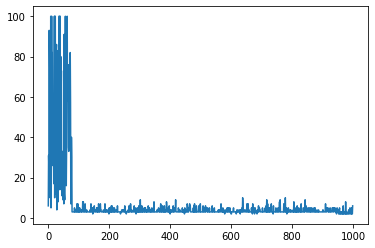

In [35]:
import matplotlib.pyplot as plt
plt.plot(steps)